<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [136]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge



import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

In [137]:
# зафиксируем random state для воспроизводимости результатов
RANDOM_STATE = 42

Будем предсказывать зарплату по описанию вакансии - это задача регрессии!

In [138]:
df = pd.read_csv('salary_data.csv', index_col = [0])

In [139]:
df.head()

,Job Title,Salary Estimate,Job Description,Rating,Company Name,Location,Headquarters,Size,Founded,Type of ownership,Industry,Sector,Revenue,Competitors,hourly,employer_provided,min_salary,max_salary,avg_salary,company_txt,job_state,same_state,age,python_yn,R_yn,spark,aws,excel
0,Data Scientist,$53K-$91K (Glassdoor est.),"Data Scientist\nLocation: Albuquerque, NM\nEducation Required: Bachelor’s degree required, prefe...",3.8,Tecolote Research\n3.8,"Albuquerque, NM","Goleta, CA",501 to 1000 employees,1973,Company - Private,Aerospace & Defense,Aerospace & Defense,$50 to $100 million (USD),-1,0,0,53,91,72.0,Tecolote Research\n,NM,0,47,1,0,0,0,1
1,Healthcare Data Scientist,$63K-$112K (Glassdoor est.),What You Will Do:\n\nI. General Summary\n\nThe Healthcare Data Scientist position will join our ...,3.4,University of Maryland Medical System\n3.4,"Linthicum, MD","Baltimore, MD",10000+ employees,1984,Other Organization,Health Care Services & Hospitals,Health Care,$2 to $5 billion (USD),-1,0,0,63,112,87.5,University of Maryland Medical System\n,MD,0,36,1,0,0,0,0
2,Data Scientist,$80K-$90K (Glassdoor est.),"KnowBe4, Inc. is a high growth information security company. We are the world's largest provider...",4.8,KnowBe4\n4.8,"Clearwater, FL","Clearwater, FL",501 to 1000 employees,2010,Company - Private,Security Services,Business Services,$100 to $500 million (USD),-1,0,0,80,90,85.0,KnowBe4\n,FL,1,10,1,0,1,0,1
3,Data Scientist,$56K-$97K (Glassdoor est.),*Organization and Job ID**\nJob ID: 310709\n\nDirectorate: Earth & Biological Sciences\n\nDivisi...,3.8,PNNL\n3.8,"Richland, WA","Richland, WA",1001 to 5000 employees,1965,Government,Energy,"Oil, Gas, Energy & Utilities",$500 million to $1 billion (USD),"Oak Ridge National Laboratory, National Renewable Energy Lab, Los Alamos National Laboratory",0,0,56,97,76.5,PNNL\n,WA,1,55,1,0,0,0,0
4,Data Scientist,$86K-$143K (Glassdoor est.),"Data Scientist\nAffinity Solutions / Marketing Cloud seeks smart, curious, technically savvy can...",2.9,Affinity Solutions\n2.9,"New York, NY","New York, NY",51 to 200 employees,1998,Company - Private,Advertising & Marketing,Business Services,Unknown / Non-Applicable,"Commerce Signals, Cardlytics, Yodlee",0,0,86,143,114.5,Affinity Solutions\n,NY,1,22,1,0,0,0,1


Посмотрим на распределение целевой переменной. Построим гистограмму распределения вероятностей признака `avg_salary`

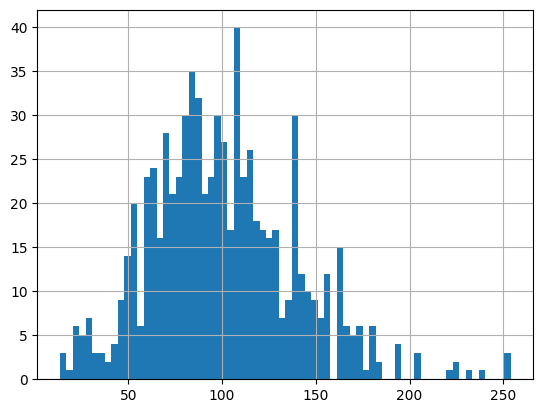

In [140]:
plt.hist(df['avg_salary'], bins=70)
plt.grid()
plt.show()

Распределение похоже на нормальное. Лучший вариант для линейной регрессии.

Найдем средние/медианные езарплаты в зависимости от профессии. Используем метод `groupby()`

In [141]:
df.groupby('Job Title')['avg_salary'].median()

Job Title
Ag Data Scientist                                      80.5
Analytics - Business Assurance Data Analyst            43.0
Analytics Consultant                                   66.5
Analytics Manager                                      87.5
Analytics Manager - Data Mart                          64.0
                                                      ...  
System and Data Analyst                                59.0
Systems Engineer II - Data Analyst                     62.5
Technology-Minded, Data Professional Opportunities     70.5
VP, Data Science                                      124.5
Web Data Analyst                                      106.0
Name: avg_salary, Length: 264, dtype: float64

In [142]:
df['Job Title'].nunique()

264

Разобъем данные на тренировочные и тестовые. Для обучения будем использовать в качестве признаков только описание вакансии `Job Description`	

In [143]:
X = df['Job Description']
y = df['avg_salary']

In [144]:
%%time
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)

CPU times: user 4.05 ms, sys: 2.17 ms, total: 6.22 ms
Wall time: 5.44 ms


Закодируйте столбец `Job Description` при помощи **tf-idf**:

* обучите (метод `fit`) на тренировочных данных `X_train`, а затем примените (`transform`) и к трейну, и к тесту в отдельности.

*  попробуйте подобрать гиперпараметры `min_df`, `max_df`, `ngram_range` у метода для достижения наилучшего качества модели

**Вопрос:** если использовать `min_df = 5`, `max_df=1.0`, `ngram_range=(1,1)`, то сколько столбцов получится в матрице после применения кодировки?

Обучите линейную регрессию `Ridge()` на тренировочных данных и сделайте предсказания на тренировочных и тестовых данных.

**model = Ridge(alpha=1.1)**

In [145]:
tfidf = TfidfVectorizer(max_df=0.7, min_df=5, ngram_range=(1, 2))
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model = Ridge(alpha=1.1)

model.fit(X_train_tfidf, y_train)

r2_train = model.score(X_train_tfidf, y_train)
print(f"R^2 на тренировочных данных: {r2_train}")
r2_test = model.score(X_test_tfidf, y_test)
print(f"R^2 на тестовых данных: {r2_test}")

R^2 на тренировочных данных: 0.8401618156758619
R^2 на тестовых данных: 0.6654780107723557


In [166]:
cvector = TfidfVectorizer()
model_cvector = Ridge(alpha=1.1)

pipeline = Pipeline([
        ('TfidfVectorizer', TfidfVectorizer()),
        ('regressor', Ridge(alpha=1.1))
])

grid_space={'TfidfVectorizer__max_df':[0.4, 0.5, 0.6, 0.7, 0.8], 
            'TfidfVectorizer__min_df':[6, 7, 8, 9], 
            'TfidfVectorizer__ngram_range':[(1, 1), (1, 2), (1, 3)]}

In [172]:
grid_search_tf = GridSearchCV(pipeline, grid_space, cv=5, scoring='r2', verbose=3)  # You can adjust the scoring metric as needed
grid_search_tf.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END TfidfVectorizer__max_df=0.4, TfidfVectorizer__min_df=6, TfidfVectorizer__ngram_range=(1, 1);, score=0.525 total time=   0.4s
[CV 2/5] END TfidfVectorizer__max_df=0.4, TfidfVectorizer__min_df=6, TfidfVectorizer__ngram_range=(1, 1);, score=0.612 total time=   0.6s
[CV 3/5] END TfidfVectorizer__max_df=0.4, TfidfVectorizer__min_df=6, TfidfVectorizer__ngram_range=(1, 1);, score=0.573 total time=   0.3s
[CV 4/5] END TfidfVectorizer__max_df=0.4, TfidfVectorizer__min_df=6, TfidfVectorizer__ngram_range=(1, 1);, score=0.539 total time=   0.3s
[CV 5/5] END TfidfVectorizer__max_df=0.4, TfidfVectorizer__min_df=6, TfidfVectorizer__ngram_range=(1, 1);, score=0.599 total time=   0.4s
[CV 1/5] END TfidfVectorizer__max_df=0.4, TfidfVectorizer__min_df=6, TfidfVectorizer__ngram_range=(1, 2);, score=0.524 total time=   0.9s
[CV 2/5] END TfidfVectorizer__max_df=0.4, TfidfVectorizer__min_df=6, TfidfVectorizer__ngram_range=(1, 2);, sco

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('TfidfVectorizer', TfidfVectorizer()),
                                       ('regressor', Ridge(alpha=1.1))]),
             param_grid={'TfidfVectorizer__max_df': [0.4, 0.5, 0.6, 0.7, 0.8],
                         'TfidfVectorizer__min_df': [6, 7, 8, 9],
                         'TfidfVectorizer__ngram_range': [(1, 1), (1, 2),
                                                          (1, 3)]},
             scoring='r2', verbose=3)

In [173]:
grid_search_tf.best_params_

{'TfidfVectorizer__max_df': 0.4,
 'TfidfVectorizer__min_df': 8,
 'TfidfVectorizer__ngram_range': (1, 3)}

Посчитаем метрику качества предсказания $R^2$. Чем ближе она к 1, тем лучше качество модели.

Посчитайте значение $R^2$ на тренировочных и на тестовых данных.

**Вопрос:** чему равен $R^2$ на тесте?

In [174]:
tfidf = TfidfVectorizer(max_df=0.4, min_df=8, ngram_range=(1, 3))
tfidf.fit(X_train)
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

model = Ridge(alpha=1.1)

model.fit(X_train_tfidf, y_train)
coefs = sorted(zip(list(np.array(tfidf.get_feature_names_out())[model.coef_ != 0]), model.coef_[model.coef_ != 0]),
               key=lambda x: -x[1])
coefs = pd.DataFrame(coefs, columns=["ngram", "weight"])


r2_train = model.score(X_train_tfidf, y_train)
print(f"R^2 на тренировочных данных: {r2_train}")
r2_test = model.score(X_test_tfidf, y_test)
print(f"R^2 на тестовых данных: {r2_test}")

R^2 на тренировочных данных: 0.8448630207853061
R^2 на тестовых данных: 0.6638485749488685


Потестируйте построенную модель. Посмотрите, как она прогнозирует зарплаты для разных вакансий

In [150]:
model.predict(tfidf.transform([u"director"]))

array([98.21237784])

In [151]:
model.predict(tfidf.transform([u"manager"]))

array([90.61927169])

**Вопрос:** посчитайте зарплату "data scientist" при помощи модели.

In [152]:
model.predict(tfidf.transform([u"data scientist"]))

array([117.88522584])

Посмотрим на веса модели

**Вопрос:** какой признак имеет наибольший положительный вес?


In [153]:

coefs = sorted(zip(list(np.array(tfidf.get_feature_names_out())[model.coef_ != 0]), model.coef_[model.coef_ != 0]),
               key=lambda x: -x[1])
coefs = pd.DataFrame(coefs, columns=["ngram", "weight"])



In [154]:
coefs

,ngram,weight
0,data science,29.697523
1,platform,27.757371
2,data scientists,27.697495
3,credit,24.889129
4,gallup,24.795073
...,...,...
15655,reporting,-22.335495
15656,marketing,-22.472873
15657,hospital,-25.157361
15658,analyst,-26.167529


Закодируйте столбец `Job Description` при помощи мешка слов.

Постройте модель линейной регрессии `Ridge()` на тренировочных данных и сделайте предсказания на тренировочных и тестовых данных, если столбец 
**model = Ridge(alpha=1.1)**

Рассчитайте метрику качества предсказания $R^2$ на тренировочных и на тестовых данных. 

Потестируйте построенную модель. Посмотрите, как она прогнозирует зарплаты для разных вакансий. Сделайте прогноз зарплаты для "data scientist" при помощи построенной модели.


**Вопрос:** Как изменилось качество модели? чему равен $R^2$ на тесте? какой признак имеет наибольший положительный вес?

In [155]:
cvector = CountVectorizer()
model_cvector = Ridge(alpha=1.1)

pipeline = Pipeline([
        ('vectorizer', CountVectorizer()),
        ('regressor', Ridge(alpha=1.1))
])

In [156]:
grid_space={'vectorizer__max_df':[0.2, 0.3, 0.4, 0.5, 0.6], 
            'vectorizer__min_df':[1, 2, 3, 4], 
            'vectorizer__ngram_range':[(1, 1), (1, 2), (1, 3)]}

In [157]:
grid_search = GridSearchCV(pipeline, grid_space, cv=5, scoring='r2', verbose=3)  # You can adjust the scoring metric as needed
grid_search.fit(X_train, y_train)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV 1/5] END vectorizer__max_df=0.2, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.518 total time=   0.5s
[CV 2/5] END vectorizer__max_df=0.2, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.672 total time=   0.4s
[CV 3/5] END vectorizer__max_df=0.2, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.677 total time=   0.4s
[CV 4/5] END vectorizer__max_df=0.2, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.555 total time=   0.4s
[CV 5/5] END vectorizer__max_df=0.2, vectorizer__min_df=1, vectorizer__ngram_range=(1, 1);, score=0.703 total time=   0.4s
[CV 1/5] END vectorizer__max_df=0.2, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.563 total time=   1.1s
[CV 2/5] END vectorizer__max_df=0.2, vectorizer__min_df=1, vectorizer__ngram_range=(1, 2);, score=0.731 total time=   1.1s
[CV 3/5] END vectorizer__max_df=0.2, vectorizer__min_df=1, vectorizer__ngram_

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer', CountVectorizer()),
                                       ('regressor', Ridge(alpha=1.1))]),
             param_grid={'vectorizer__max_df': [0.2, 0.3, 0.4, 0.5, 0.6],
                         'vectorizer__min_df': [1, 2, 3, 4],
                         'vectorizer__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             scoring='r2', verbose=3)

In [158]:
grid_search.best_params_, grid_search.best_score_

({'vectorizer__max_df': 0.3,
  'vectorizer__min_df': 2,
  'vectorizer__ngram_range': (1, 3)},
 0.6637108593028205)

In [159]:
cvector = CountVectorizer(max_df=0.3, min_df=2, ngram_range=(1, 3))

cvector.fit(X_train)


X_train_cvector = cvector.transform(X_train)
X_test_cvector = cvector.transform(X_test)

In [160]:
model_cv = Ridge(alpha=1.1)
model_cv.fit(X_train_cvector, y_train)

Ridge(alpha=1.1)

In [161]:
r2_train = model_cv.score(X_train_cvector, y_train)
print(f"R^2 на тренировочных данных: {r2_train}")
r2_test = model_cv.score(X_test_cvector, y_test)
print(f"R^2 на тестовых данных: {r2_test}")

R^2 на тренировочных данных: 0.9999316718732523
R^2 на тестовых данных: 0.8260067845537492
